In [332]:
import pandas as pd
import numpy as np
import ast
import re
import string
from nltk.corpus import stopwords
import nltk
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize, sent_tokenize
import torch
from diffusers import StableDiffusionPipeline
from PIL import Image
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import f1_score
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

In [333]:
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

## EDA and cleaning:

In [334]:
with open(r"C:\Users\saras\Downloads\booksummaries.txt", encoding="utf8") as file:
    data = file.readlines()

### Converting the data to dataset.

In [335]:
dataset = []
for line in data:    
    parts = line.split('\t')
    book_id = parts[0]
    name = parts[2]
    author = parts[3]
    publication_year = parts[4]
    genres = parts[5]
    summary = parts[6]
    books = {"id":book_id, "name":name, "author":author, "publication year":publication_year, "genres":genres, "summary":summary}
    dataset.append(books)
    
df = pd.DataFrame(dataset)

In [336]:
df.head()

,id,name,author,publication year,genres,summary
0,620,Animal Farm,George Orwell,1945-08-17,"{""/m/016lj8"": ""Roman \u00e0 clef"", ""/m/06nbt"":...","Old Major, the old boar on the Manor Farm, ca..."
1,843,A Clockwork Orange,Anthony Burgess,1962,"{""/m/06n90"": ""Science Fiction"", ""/m/0l67h"": ""N...","Alex, a teenager living in near-future Englan..."
2,986,The Plague,Albert Camus,1947,"{""/m/02m4t"": ""Existentialism"", ""/m/02xlf"": ""Fi...",The text of The Plague is divided into five p...
3,1756,An Enquiry Concerning Human Understanding,David Hume,,,The argument of the Enquiry proceeds by a ser...
4,2080,A Fire Upon the Deep,Vernor Vinge,,"{""/m/03lrw"": ""Hard science fiction"", ""/m/06n90...",The novel posits that space around the Milky ...


### Dropping unnecessary columns.

In [337]:
df.drop(['id'], axis=1, inplace=True)

### Converting empty cells  to NaN values.

In [338]:
df.replace("", np.NaN, inplace=True)

### Extracting genre names.

In [339]:
df['genres'] = df['genres'].apply(lambda x: list(ast.literal_eval(x).values()) if pd.notna(x) else np.NaN)
df['genres'] = df['genres'].apply(lambda x: ", ".join(x) if isinstance(x, list) else np.NaN)

### Extracting the publication year.

In [340]:
df["publication year"] = df["publication year"].str[:4]

### Changing data types of some columns.

In [341]:
df.dtypes

name                object
author              object
publication year    object
genres              object
summary             object
dtype: object

In [342]:
df = df.astype({'publication year': pd.Int32Dtype()})

### Some information about the dataset:

In [343]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16559 entries, 0 to 16558
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   name              16559 non-null  object
 1   author            14177 non-null  object
 2   publication year  10949 non-null  Int32 
 3   genres            12841 non-null  object
 4   summary           16559 non-null  object
dtypes: Int32(1), object(4)
memory usage: 598.4+ KB


In [344]:
df.isnull().sum()

name                   0
author              2382
publication year    5610
genres              3718
summary                0
dtype: int64

In [345]:
df.duplicated().sum()

0

In [346]:
df.describe(include="all")

,name,author,publication year,genres,summary
count,16559,14177,10949.000000,12841,16559
unique,16277,4714,NaN,2154,16532
top,Nemesis,Agatha Christie,NaN,Novel,~Plot outline description~ --> <!--\n
freq,6,74,NaN,839,13
mean,NaN,NaN,1975.924194,NaN,NaN
std,NaN,NaN,49.641921,NaN,NaN
min,NaN,NaN,398.000000,NaN,NaN
25%,NaN,NaN,1966.000000,NaN,NaN
50%,NaN,NaN,1991.000000,NaN,NaN
75%,NaN,NaN,2003.000000,NaN,NaN


In [347]:
df["publication year"].describe()

count    10949.000000
mean      1975.924194
std         49.641921
min        398.000000
25%       1966.000000
50%       1991.000000
75%       2003.000000
max       2013.000000
Name: publication year, dtype: float64

In [348]:
df.head()

,name,author,publication year,genres,summary
0,Animal Farm,George Orwell,1945,"Roman à clef, Satire, Children's literature, S...","Old Major, the old boar on the Manor Farm, ca..."
1,A Clockwork Orange,Anthony Burgess,1962,"Science Fiction, Novella, Speculative fiction,...","Alex, a teenager living in near-future Englan..."
2,The Plague,Albert Camus,1947,"Existentialism, Fiction, Absurdist fiction, Novel",The text of The Plague is divided into five p...
3,An Enquiry Concerning Human Understanding,David Hume,<NA>,NaN,The argument of the Enquiry proceeds by a ser...
4,A Fire Upon the Deep,Vernor Vinge,<NA>,"Hard science fiction, Science Fiction, Specula...",The novel posits that space around the Milky ...


### Distribution of publication year:

<AxesSubplot:xlabel='publication year'>

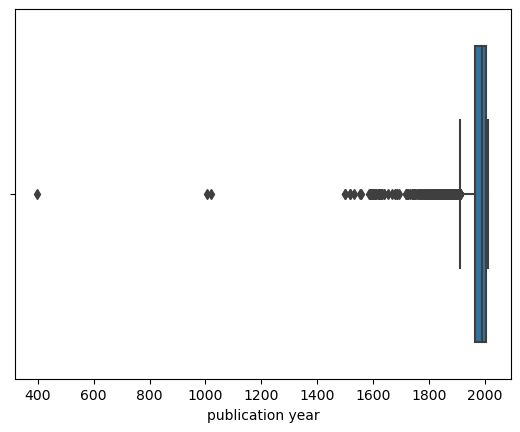

In [349]:
filtered_df = df[df["publication year"].notna()]["publication year"]
sns.boxplot(x=filtered_df)

In [350]:
df.loc[df["publication year"] < 1400]

,name,author,publication year,genres,summary
408,The Tale of Genji,Murasaki Shikibu,1021,Fiction,The work recounts the life of a son of the Ja...
1381,The Confessions of St. Augustine,Augustine of Hippo,398,Non-fiction,The work outlines Augustine's sinful youth an...
11333,The Wizard of London,Mercedes Lackey,1005,"Speculative fiction, Fantasy",As an acting prequel to the Elemental Masters...


### The oldest book in the dataset:

In [351]:
df.loc[df["publication year"] == min(filtered_df)]

,name,author,publication year,genres,summary
1381,The Confessions of St. Augustine,Augustine of Hippo,398,Non-fiction,The work outlines Augustine's sinful youth an...


### Book count per genre plot:

Text(0, 0.5, 'Genre')

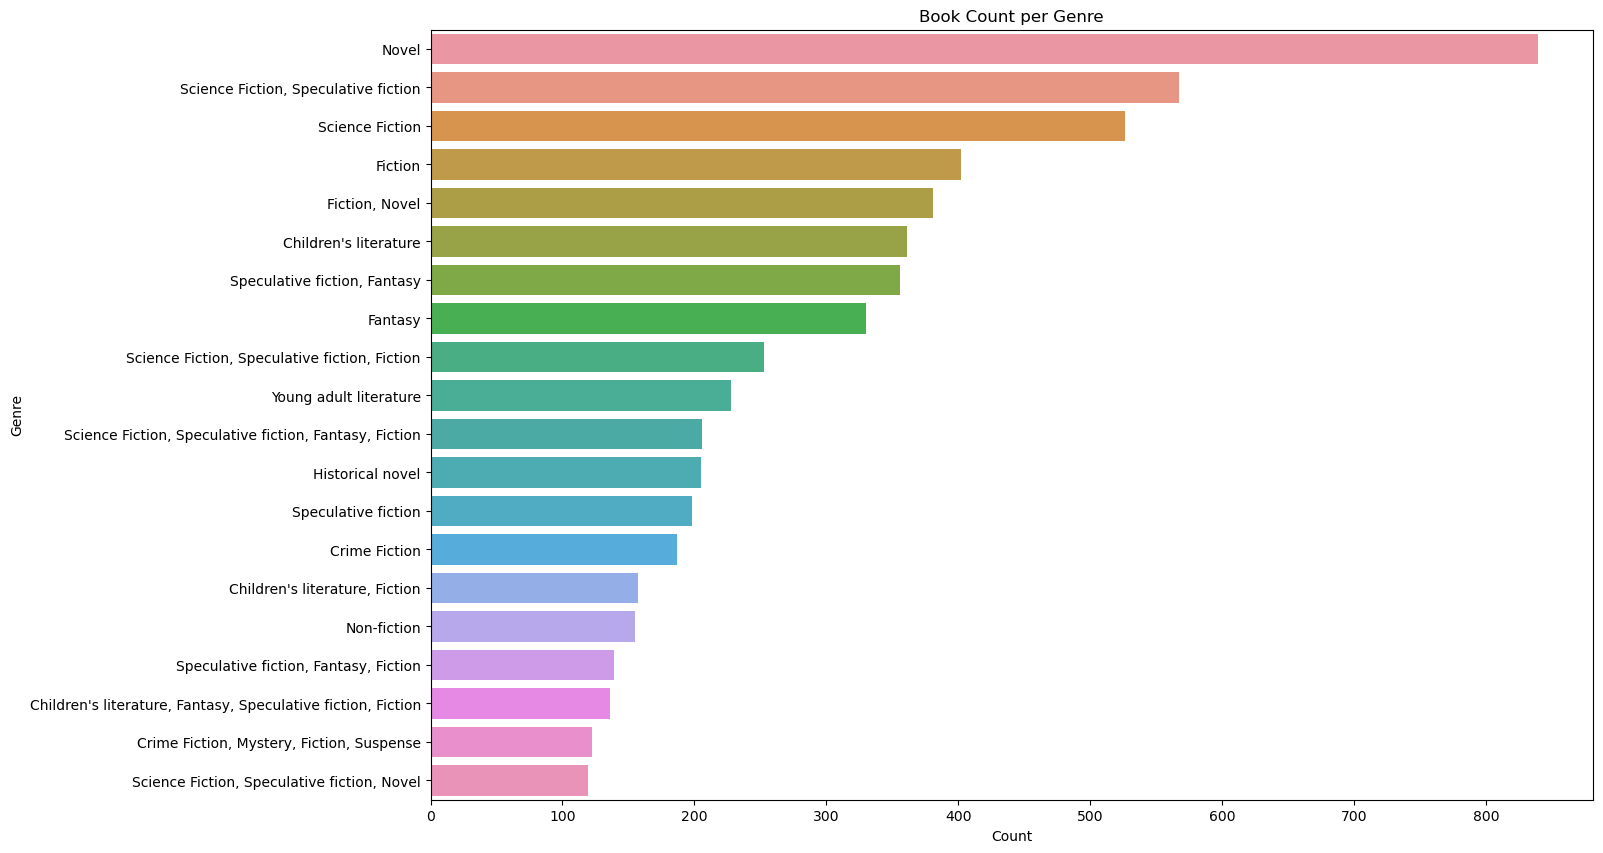

In [352]:
genre_counts = df['genres'].value_counts().reset_index().head(20)
genre_counts.columns = ['genres', 'count']
plt.figure(figsize=(15,10)) 
sns.barplot(data=genre_counts, x='count', y='genres')
plt.title('Book Count per Genre')
plt.xlabel('Count')
plt.ylabel('Genre')

### Book count per author plot:

Text(0, 0.5, 'Author')

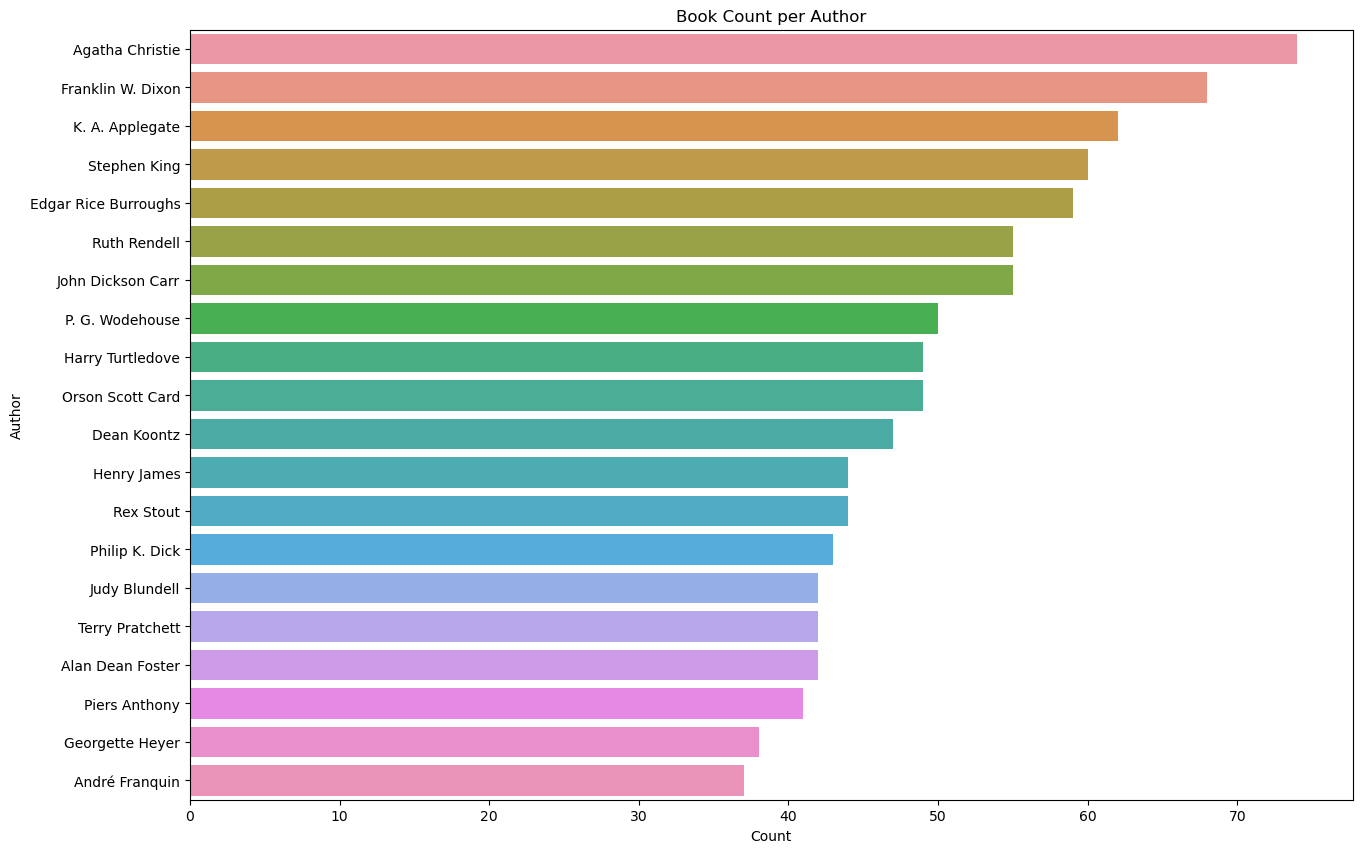

In [353]:
author_counts = df['author'].value_counts().reset_index().head(20)
author_counts.columns = ['authors', 'count']
plt.figure(figsize=(15,10)) 
sns.barplot(data=author_counts, x='count', y='authors')
plt.title('Book Count per Author')
plt.xlabel('Count')
plt.ylabel('Author')

### Word cloud for different genres:

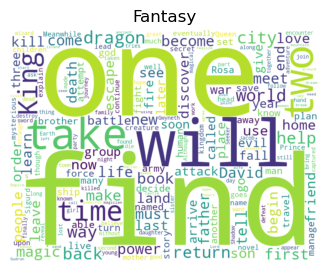

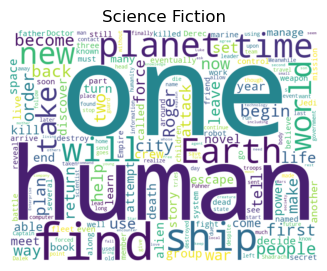

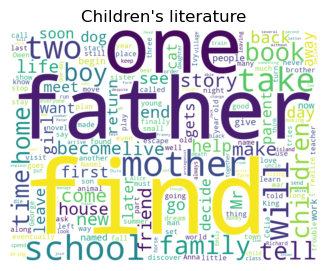

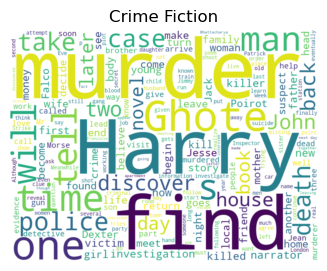

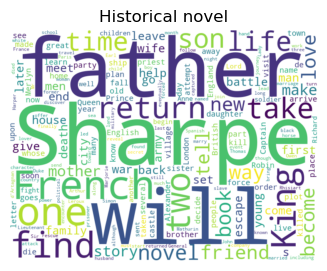

In [354]:
for genre in ["Fantasy", "Science Fiction", "Children's literature", "Crime Fiction", "Historical novel"]:    
    text = ' '.join(df.loc[df["genres"]==genre]["summary"])
    wordcloud = WordCloud(width=800, height=600, background_color='white').generate(text)
    plt.figure(figsize=(5, 3))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(genre)
    plt.show()

## Conclusion from the EDA on Text Data:
### Popular Book and Author: "Nemesis" appears to be the most repeated book name, suggesting it might be a popular or significant work within the dataset. Agatha Christie stands out as the author with the most published books, indicating her prolific contribution to the dataset.
### Publishing Trends: The majority of the books in the dataset were published in 2007, indicating a potential peak in publishing activity during that year. This could be due to various factors such as literary trends, market demands, or specific events in the publishing industry.
### Historical Context: The dataset contains a wide range of publication dates, with the oldest book being "The Confessions of St. Augustine" by Augustine of Hippo, dating back to 398. This suggests diversity in the temporal origins of the texts, potentially spanning centuries.
### Genre Preferences: The most repeated genre is the novel, highlighting its popularity or prevalence within the dataset. This could indicate that novels constitute a significant portion of the texts under analysis, reflecting broader reading preferences or publishing trends.
### Common Themes: The analysis of summaries reveals that words like "find" and "one" are among the most repeated. This may suggest common themes across the texts, such as quests, discoveries, or singular narratives.
### Character Analysis: Within the crime fiction genre, the name "Harry" emerges as one of the most repeated. This could indicate the prominence of a recurring character or archetype named Harry within the genre, potentially offering insights into character preferences or narrative conventions.

### Handling missing values of "publication year" feature.

In [355]:
df["publication year"].fillna(df["publication year"].mode()[0], inplace=True)

### Preprocessing functions:

In [356]:
def lower_case(text):
    #return df.applymap(lambda x: x.lower() if isinstance(x, str) else x)
    return text.lower()

In [357]:
def remove_numbers(text):
    #return df.applymap(lambda x: re.sub(r'\d+', '', x) if isinstance(x, str) else x)
    return re.sub(r'\d+', '', text)

In [358]:
def remove_punctuation(text):
    translator = str.maketrans('', '', string.punctuation)
    #return df.applymap(lambda x: x.translate(translator) if isinstance(x, str) else x)
    return text.translate(translator)

In [359]:
def remove_whitespace(text):
    #return df.applymap(lambda x: " ".join(x.split()) if isinstance(x, str) else x)
    return " ".join(text.split())

In [360]:
def remove_stopwords(text):
    stop_words = set(stopwords.words('english'))
    words = text.split()
    filtered_words = [word for word in words if word.lower() not in stop_words]
    return ' '.join(filtered_words)

In [361]:
def tokenization(text):
    #return df.applymap(lambda x: word_tokenize(x) if isinstance(x, str) else x)
    return word_tokenize(text)

In [362]:
def stemming(text):
    singles = [stemmer.stem(word) for word in text]
    return singles

In [363]:
def lemmatizing(text):
    lemm_text = [lemmatizer.lemmatize(word) for word in text]
    return lemm_text

In [364]:
def clean_summary(summary):
    summary = lower_case(summary)
    summary = remove_numbers(summary)
    summary = remove_punctuation(summary)
    summary = remove_whitespace(summary)
    summary = remove_stopwords(summary)
    summary = tokenization(summary)
    summary = stemming(summary)
    return ' '.join(summary)

In [365]:
df_temp = df.copy()
df_temp["summary"] = df_temp["summary"].apply(lambda x: clean_summary(x))

### Generating a model for book genre prediction

In [366]:
# filter dataframe to learn the model
classified_summary_with_genre = df_temp[df_temp["genres"].notna()][["genres", "summary"]]
x = classified_summary_with_genre["summary"]
y = classified_summary_with_genre["genres"] 

# Split data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# TF-IDF Vectorization
vectorizer = TfidfVectorizer(ngram_range=(1,1), use_idf=True)
X_train_tfidf = vectorizer.fit_transform(x_train)
X_test_tfidf = vectorizer.transform(x_test)

In [319]:
# Train Naive Bayes classifier
nb_clf = MultinomialNB()
nb_clf.fit(X_train_tfidf, y_train)

#make predictions
predictions = nb_clf.predict(X_test_tfidf)
accuracy = accuracy_score(y_test, predictions)
accuracy

0.09964966913195795

In [320]:
# Train Logistic Regression classifier
lr = LogisticRegression()
lr_clf = OneVsRestClassifier(lr)
lr_clf.fit(X_train_tfidf, y_train)

#make predictions
predictions = lr_clf.predict(X_test_tfidf)
accuracy = accuracy_score(y_test, predictions)
accuracy

0.17983651226158037

In [ ]:
# Train SVM classifier
svm_clf = SVC(kernel='linear', C=1.0)
svm_clf.fit(X_train_tfidf, y_train)

#make predictions
predictions = svm_clf.predict(X_test_tfidf)
accuracy = accuracy_score(y_test, predictions)
accuracy

### Handling missing values of "genres" feature with genre prediction model.

In [226]:
for i in range(len(df_temp)):
    if pd.isnull(df_temp.loc[i, 'genres']):
        summary_vector = vectorizer.transform([df_temp.loc[i, 'summary']])
        predicted_genre = svm_clf.predict(summary_vector)
        df.loc[i, 'genres'] = predicted_genre

### Generating a model for author prediction

In [324]:
# filter dataframe to learn the model
classified_summary_with_author = df_temp[df_temp["author"].notna()][["author", "summary"]]
x = classified_summary_with_author["summary"]
y = classified_summary_with_author["author"] 

# Split data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# TF-IDF Vectorization
vectorizer = TfidfVectorizer(ngram_range=(1,1), use_idf=True) # Adjust max_features as needed?
X_train_tfidf = vectorizer.fit_transform(x_train)
X_test_tfidf = vectorizer.transform(x_test)

In [325]:
# Train Naive Bayes classifier
nb_clf = MultinomialNB()
nb_clf.fit(X_train_tfidf, y_train)

#make predictions
predictions = nb_clf.predict(X_test_tfidf)
accuracy = accuracy_score(y_test, predictions)
accuracy

0.07581100141043723

In [326]:
# Train Logistic Regression classifier
lr = LogisticRegression()
lr_clf = OneVsRestClassifier(lr)
lr_clf.fit(X_train_tfidf, y_train)

#make predictions
predictions = lr_clf.predict(X_test_tfidf)
accuracy = accuracy_score(y_test, predictions)
accuracy

0.14844851904090267

In [327]:
# Train SVM classifier
svm_clf = SVC(kernel='linear', C=1.0)
svm_clf.fit(X_train_tfidf, y_train)

#make predictions
predictions = svm_clf.predict(X_test_tfidf)
accuracy = accuracy_score(y_test, predictions)
accuracy

0.2143864598025388

### Handling missing values of "author" feature with genre prediction model.

In [ ]:
for i in range(len(df_temp)):
    if pd.isnull(df_temp.loc[i, 'author']):
        summary_vector = vectorizer.transform([df_temp.loc[i, 'summary']])
        predicted_genre = svm_clf.predict(summary_vector)
        df.loc[i, 'genres'] = predicted_genre

### Extracting text values.

In [96]:
textual_columns = df.select_dtypes(include=['object']).columns
df_text = df[textual_columns]

In [97]:
df_text.head()

,name,author,genres,summary
0,Animal Farm,George Orwell,"Roman à clef, Satire, Children's literature, S...","Old Major, the old boar on the Manor Farm, ca..."
1,A Clockwork Orange,Anthony Burgess,"Science Fiction, Novella, Speculative fiction,...","Alex, a teenager living in near-future Englan..."
2,The Plague,Albert Camus,"Existentialism, Fiction, Absurdist fiction, Novel",The text of The Plague is divided into five p...
3,An Enquiry Concerning Human Understanding,David Hume,NaN,The argument of the Enquiry proceeds by a ser...
4,A Fire Upon the Deep,Vernor Vinge,"Hard science fiction, Science Fiction, Specula...",The novel posits that space around the Milky ...


In [98]:
df_text.dtypes

name       object
author     object
genres     object
summary    object
dtype: object

### Cleaning df_text:

In [99]:
df_text = df_text.applymap(lambda x: lower_case(x) if isinstance(x, str) else x)
df_text["summary"] = df_text["summary"].apply(lambda x: lower_case(x) if isinstance(x, str) else x)
df_text = remove_numbers(df_text) 
df_text = remove_punctuation(df_text)
df_text = remove_whitespace(df_text)
df_text = df_text.applymap(lambda x: remove_stopwords(x) if isinstance(x, str) else x)
df_text = tokenization(df_text)
df_text = df_text.applymap(lambda x: stemming(x) if isinstance(x, list) else [])

In [100]:
df_text.head()

,name,author,genres,summary
0,animal farm,george orwell,"roman à clef, satire, children's literature, s...","old major, old boar manor farm, calls animals ..."
1,clockwork orange,anthony burgess,"science fiction, novella, speculative fiction,...","alex, teenager living near-future england, lea..."
2,plague,albert camus,"existentialism, fiction, absurdist fiction, novel","text plague divided five parts. town oran, tho..."
3,enquiry concerning human understanding,david hume,NaN,argument enquiry proceeds series incremental s...
4,fire upon deep,vernor vinge,"hard science fiction, science fiction, specula...",novel posits space around milky way divided co...


In [78]:
def summarizer(text):
    freqTable = dict() 
    for word in text:
        word = word.lower() 
        stopWords = set(stopwords.words('english'))
        if word in stopWords: 
            continue
        if word in freqTable: 
            freqTable[word] += 1
        else: 
            freqTable[word] = 1
   
    # Creating a dictionary to keep the score of each sentence 
    sentences = sent_tokenize(text) 
    sentenceValue = dict() 
   
    for sentence in sentences: 
        for word, freq in freqTable.items(): 
            if word in sentence.lower(): 
                if sentence in sentenceValue: 
                    sentenceValue[sentence] += freq 
                else: 
                    sentenceValue[sentence] = freq 
   
    sumValues = 0
    for sentence in sentenceValue: 
        sumValues += sentenceValue[sentence] 
   
    # Average value of a sentence from the original text 
   
    average = int(sumValues / len(sentenceValue)) 
   
    # Storing sentences into our summary. 
    summary = ''
    coef = 1.2        
    while (summary == '') and (coef >= 1):
        for sentence in sentences: 
            if (sentence in sentenceValue) and (sentenceValue[sentence] > (coef * average)): 
                summary += " " + sentence
        coef -= 0.01
    
    return summary

### summarizing the books' summary:

In [ ]:
df_output = df[["name","summary"]]

In [19]:
df_output["condensed summaries"] = df_output["summary"].apply(lambda x: summarizer(x))

In [22]:
df_output.head()

,name,summary,condensed summaries
0,Animal Farm,"Old Major, the old boar on the Manor Farm, ca...","Benjamin, the cynical donkey, who ""could read..."
1,A Clockwork Orange,"Alex, a teenager living in near-future Englan...",Characterized as a sociopath and a hardened j...
2,The Plague,The text of The Plague is divided into five p...,"Towards the end of October, Castel's new anti..."
3,An Enquiry Concerning Human Understanding,The argument of the Enquiry proceeds by a ser...,(Hume 1974:356-359) Having dispensed with the...
4,A Fire Upon the Deep,The novel posits that space around the Milky ...,"The expedition's facility, called High Lab, i..."


In [ ]:
def image_generation(text):
    pipeline = StableDiffusionPipeline.from_pretrained(
    "stabilityai/stable-diffusion-2-1", torch_dtype=torch.float16)
    pipeline = pipeline.to('cuda')
    image = pipeline(prompt=text).images[0]
    return image

In [ ]:
df_output["images"] = df_output["condensed summaries"].apply(lambda x: image_generation(x))